In [145]:
import os
import sys
from pathlib import Path

SRC_PATH = Path(__name__).resolve().parents[1]

sys.path.append(str(SRC_PATH))

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score

In [234]:
pmu_data = pd.read_csv("../data/pmu.csv")

In [235]:
pmu_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 709090 entries, 0 to 709089
Data columns (total 27 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   timestamp         709090 non-null  object 
 1   Frequency         709090 non-null  float64
 2   DeFrequency       709090 non-null  float64
 3   Voltage_R         709090 non-null  float64
 4   Voltage_R_Angle   709090 non-null  float64
 5   Voltage_S         709090 non-null  float64
 6   Voltage_S_Angle   709090 non-null  float64
 7   Voltage_T         709090 non-null  float64
 8   Voltage_T_Angle   709090 non-null  float64
 9   Voltage_Z         709090 non-null  float64
 10  Voltage_Z_Angle   709090 non-null  float64
 11  Current_I1        709090 non-null  float64
 12  Current_I1_Angle  709090 non-null  float64
 13  Current_I2        709090 non-null  float64
 14  Current_I2_Angle  709090 non-null  float64
 15  Current_I3        709090 non-null  float64
 16  Current_I3_Angle  70

In [98]:
pmu_data.describe()

,Frequency,DeFrequency,Voltage_R,Voltage_R_Angle,Voltage_S,Voltage_S_Angle,Voltage_T,Voltage_T_Angle,Voltage_Z,Voltage_Z_Angle,...,Current_I4,Current_I4_Angle,Current_I5,Current_I5_Angle,Current_I6,Current_I6_Angle,Current_I7,Current_I7_Angle,Current_I8,Current_I8_Angle
count,709090.000000,7.090900e+05,709090.000000,709090.000000,709090.000000,709090.000000,709090.000000,709090.000000,709090.000000,709090.000000,...,709090.000000,709090.000000,709090.000000,709090.000000,709090.000000,709090.000000,709090.000000,709090.000000,709090.000000,709090.000000
mean,60.019941,1.184612e-07,66.237214,2.101883,66.359306,2.108132,66.381359,2.109040,66.200790,2.108684,...,0.670557,-0.788619,0.667745,-0.785966,0.670419,-0.788543,0.670345,-0.785214,0.670045,-0.792042
std,0.035354,5.603161e-03,0.251574,102.723008,0.252127,102.723237,0.252176,102.723698,0.251530,102.723196,...,0.002321,105.410154,0.002312,105.410285,0.002321,105.410172,0.002321,105.410311,0.002321,105.410105
min,59.904003,-8.399963e-02,65.659195,-179.989951,65.778122,-179.989951,65.797554,-179.989951,65.624573,-179.989951,...,0.664498,-179.999964,0.662252,-179.999964,0.664887,-179.999964,0.664734,-179.999964,0.663734,-179.999964
25%,59.994003,-3.997803e-03,65.959015,-85.329984,66.078300,-85.329984,66.097900,-85.329984,65.924232,-85.329984,...,0.668501,-91.449977,0.665249,-91.439984,0.667886,-91.439977,0.667733,-91.439977,0.667733,-91.449977
50%,60.024002,0.000000e+00,66.348770,2.849999,66.468529,2.864999,66.488365,2.869999,66.303795,2.864999,...,0.671503,-2.909999,0.668245,-2.904999,0.671886,-2.909999,0.671731,-2.904999,0.670732,-2.909999
75%,60.048004,3.997803e-03,66.438713,91.459983,66.558578,91.459983,66.578476,91.469982,66.393692,91.459983,...,0.672504,91.709981,0.669244,91.719974,0.671886,91.709981,0.671731,91.719981,0.671731,91.709981
max,60.125004,7.500076e-02,66.698547,179.989951,66.828735,179.989951,66.848785,179.989951,66.663383,179.989951,...,0.674505,179.990037,0.672241,179.990037,0.674885,179.990023,0.674730,179.990023,0.674730,179.990037


In [236]:
pmu_data

,timestamp,Frequency,DeFrequency,Voltage_R,Voltage_R_Angle,Voltage_S,Voltage_S_Angle,Voltage_T,Voltage_T_Angle,Voltage_Z,...,Current_I4,Current_I4_Angle,Current_I5,Current_I5_Angle,Current_I6,Current_I6_Angle,Current_I7,Current_I7_Angle,Current_I8,Current_I8_Angle
0,2024-10-05 00:00:00.000,60.061005,-0.004002,66.268814,-41.509990,66.388481,-41.489988,66.408272,-41.469989,66.223885,...,0.671503,135.799979,0.668245,135.789966,0.670886,135.799966,0.670732,135.789966,0.670732,135.819965
1,2024-10-05 00:00:00.016,60.052002,0.009003,66.258820,-41.409992,66.378471,-41.389990,66.408272,-41.359992,66.223885,...,0.671503,135.899960,0.668245,135.899960,0.670886,135.889960,0.670732,135.879961,0.670732,135.909973
2,2024-10-05 00:00:00.033,60.049004,0.002998,66.268814,-41.309988,66.388481,-41.289993,66.408272,-41.269991,66.233871,...,0.671503,135.989982,0.669244,135.969969,0.670886,135.999954,0.670732,135.979969,0.670732,136.009967
3,2024-10-05 00:00:00.050,60.054005,-0.005001,66.268814,-41.209991,66.388481,-41.189989,66.418282,-41.169990,66.233871,...,0.671503,136.119960,0.668245,136.089962,0.670886,136.109961,0.670732,136.099961,0.670732,136.109974
4,2024-10-05 00:00:00.066,60.052002,0.002003,66.278816,-41.109993,66.398483,-41.089991,66.418282,-41.069992,66.233871,...,0.671503,136.219968,0.668245,136.189970,0.670886,136.209968,0.671731,136.199969,0.670732,136.209982
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
709085,2024-10-05 03:16:46.833,59.974003,-0.007999,65.959015,-112.299969,66.088303,-112.279977,66.107918,-112.259972,65.924232,...,0.668501,65.099988,0.665249,65.099988,0.667886,65.109987,0.667733,65.099988,0.667733,65.099988
709086,2024-10-05 03:16:46.850,59.971004,0.002998,65.969009,-112.439974,66.088303,-112.419976,66.107918,-112.399970,65.934227,...,0.668501,64.979988,0.665249,64.959983,0.667886,64.979981,0.667733,64.949983,0.667733,64.959983
709087,2024-10-05 03:16:46.866,59.977001,-0.005997,65.959015,-112.559974,66.078300,-112.549975,66.107918,-112.519976,65.924232,...,0.668501,64.839990,0.665249,64.829984,0.667886,64.869981,0.667733,64.839983,0.667733,64.849982
709088,2024-10-05 03:16:46.883,59.964005,0.012997,65.969009,-112.729970,66.088303,-112.709979,66.107918,-112.679973,65.934227,...,0.668501,64.689992,0.665249,64.689978,0.667886,64.699985,0.667733,64.659980,0.667733,64.699991


In [7]:
from src.detectors import FrequencyDetector, TKEODetector, ZscoreDetector, ROCOFDetector

In [238]:
fr_detector = FrequencyDetector()
fr_anomailes = fr_detector.detect(pmu_data["Frequency"].values, threshold=0.2)
fr_anomailes.sum()

0

In [239]:
class ROCOFDetector:
    def detect(self, rocof: np.ndarray, threshold=0.0124) -> np.ndarray:
        # rocof = np.diff(frequency, prepend=frequency[0])  # Rate of Change of Frequency
        anomalies = np.abs(rocof) > threshold
        return anomalies
    
rocof_detector = ROCOFDetector()

rocof_anomailes = rocof_detector.detect(pmu_data["DeFrequency"].values, threshold=0.0224)
rocof_anomailes.sum()

427

In [240]:
zscore_detector = ZscoreDetector()
feature_list = ["Frequency", "DeFrequency", "Voltage_R", "Voltage_S", "Voltage_T", "Voltage_R_Angle", "Voltage_S_Angle", "Voltage_T_Angle", "Current_I1", "Current_I2", "Current_I3", "Current_I1_Angle", "Current_I2_Angle", "Current_I3_Angle"]

zscore_anomailes = zscore_detector.detect(pmu_data, feature_list, threshold=3)
zscore_anomailes.sum()

4787

In [241]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaled_feats = scaler.fit_transform(pmu_data[feature_list])

In [242]:
scaled_pmu_data = pd.DataFrame(scaled_feats, columns=scaler.get_feature_names_out())

In [243]:
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)

X_low = pca1.fit_transform(scaled_pmu_data)
X2 = pca1.inverse_transform(X_low)

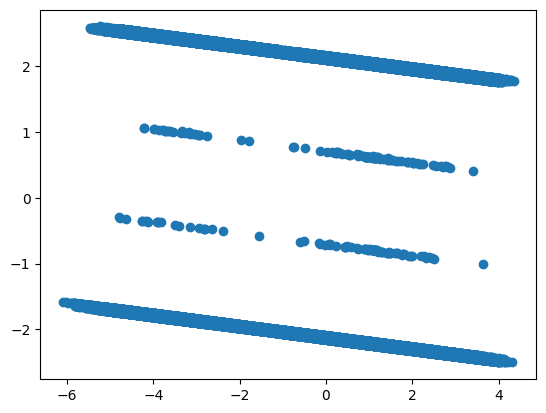

In [244]:
plt.scatter(X_low[:,0], X_low[:, 1])

In [245]:
inverse_pmu_data = pd.DataFrame(X2, columns=scaler.get_feature_names_out())

In [246]:
def anomalyScores(originalDF, reducedDF):
    loss = np.sum((np.array(originalDF)-np.array(reducedDF))**2, axis=1)
    loss = pd.Series(data=loss,index=originalDF.index)
    loss = (loss-np.min(loss))/(np.max(loss)-np.min(loss))
    return loss

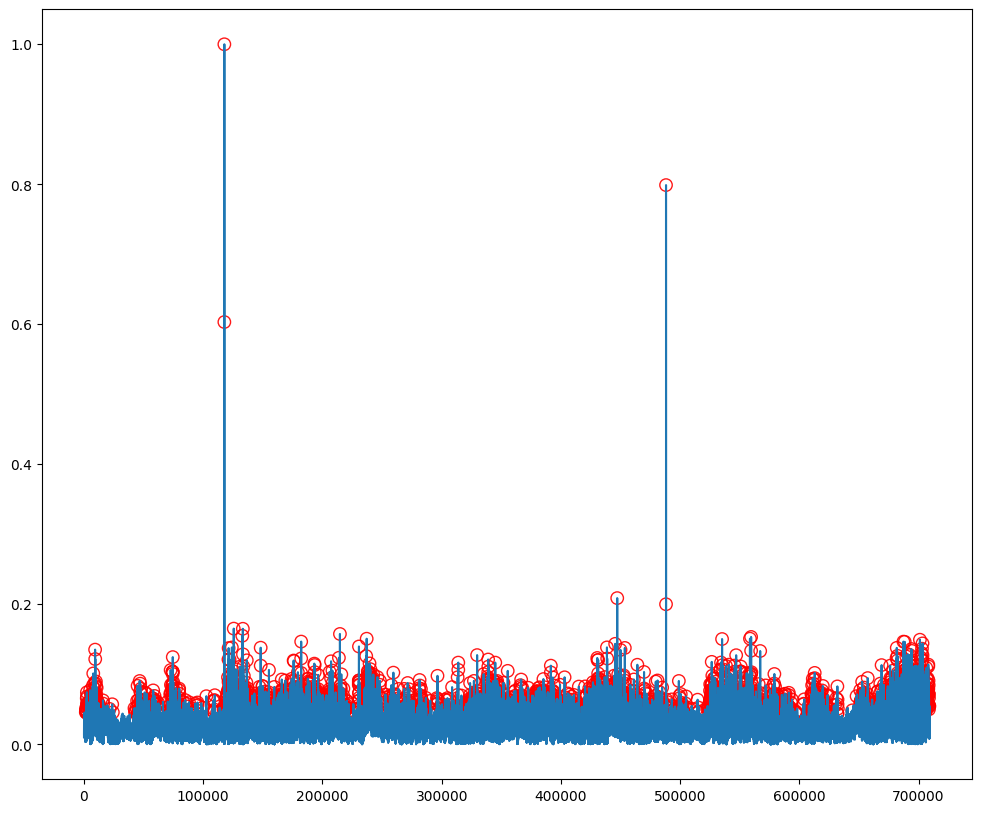

In [247]:
losses = anomalyScores(scaled_pmu_data, inverse_pmu_data)

plt.figure(figsize=(12, 10))
plt.plot(losses)
plt.scatter(np.arange(0, len(losses))[zscore_anomailes], losses[zscore_anomailes], s=80, facecolors='none', edgecolors='red', alpha=0.9)

In [248]:
z_ano = zscore_anomailes.iloc[:10000].copy()
test = pmu_data.iloc[:10000].copy()

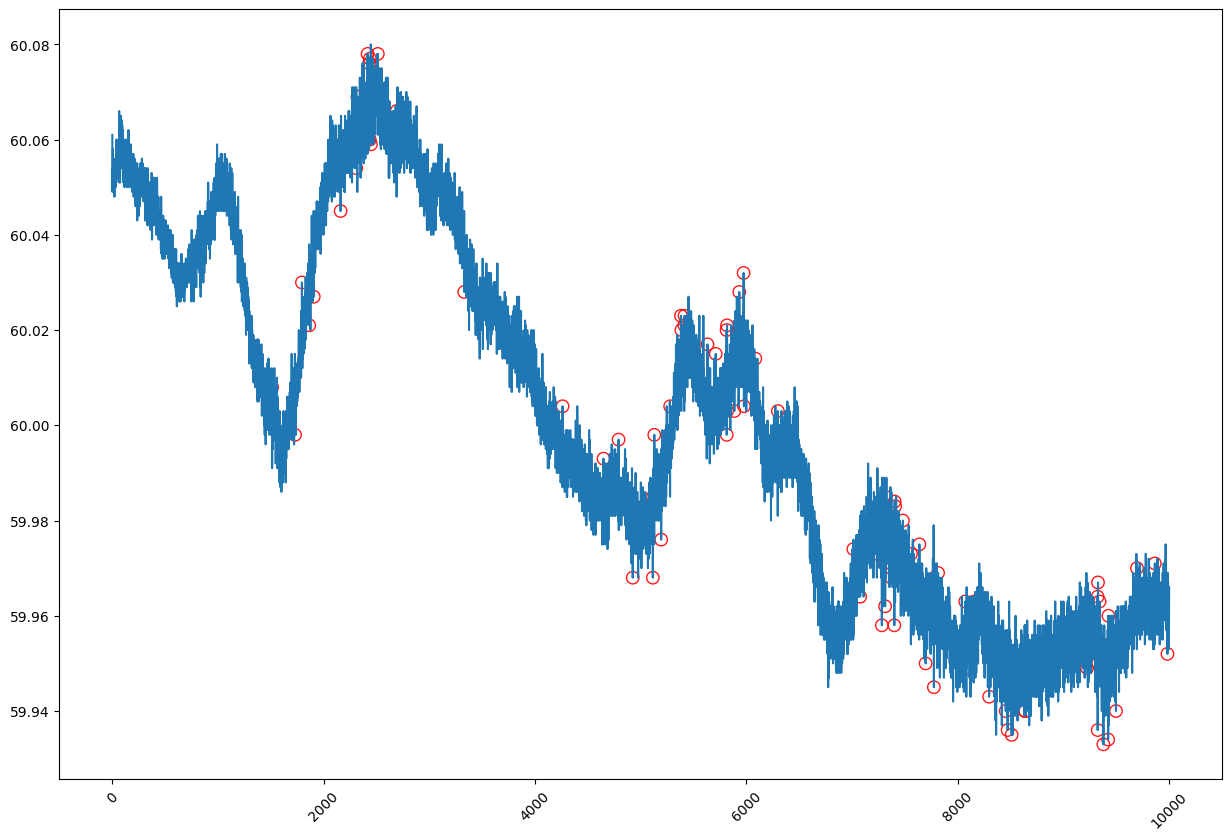

In [249]:
fig, ax = plt.subplots(figsize=(15, 10))

ax.plot(test.index, test["Frequency"])
ax.scatter(test.index[z_ano], test["Frequency"][z_ano], s=80, facecolors='none', edgecolors='red', alpha=0.9)
plt.xticks(rotation=45);

In [250]:


def extract_anomaly_windows(
    anomaly_indices: np.ndarray, window_size_before: int, window_size_after: int
) -> list:

    anomalies = np.sort(anomaly_indices)

    window = []

    start = max(0, anomalies[0] - window_size_before)
    end = anomalies[0] + window_size_after

    for index in anomalies[1:]:
        new_start = max(0, index - window_size_before)
        new_end = index + window_size_after

        if new_start <= end:
            end = max(end, new_end)
        else:
            window.append((start, end))
            start = new_start
            end = new_end

    window.append((start, end))

    return window


indices = np.array(z_ano.index[z_ano])

windows = extract_anomaly_windows(indices, window_size_before=10, window_size_after=10)

In [205]:
test_time = pmu_data.iloc[:500].copy()

In [223]:
import datetime
test_time["timestamp"] = pd.to_datetime(test_time["timestamp"])
test_time["timestamp"] = test_time["timestamp"].apply(lambda x : datetime.datetime.strftime(x, '%Y-%m-%d %H:%M:%S:%f'))

In [224]:
test_time.to_csv("test.csv", index=False)

In [262]:
import datetime

def save_event_data(pmu_data:pd.DataFrame, anomalie_indices:np.ndarray, pad_sequence_length=100)-> None:
    windows = extract_anomaly_windows(anomalie_indices, window_size_before=pad_sequence_length, window_size_after=pad_sequence_length)
    for i, window in enumerate(windows):
        start = window[0]
        end = window[1]
        start_time = pmu_data["timestamp"][start].replace(" ", "-").replace(":", "-").replace(".", "-")
        end_time = pmu_data["timestamp"][end].replace(" ", "-").replace(":", "-").replace(".", "-")
        print("====== Save Files =======")
        print(f"../event_log/event_data_{start_time}_{end_time}.csv")
        saved_data = pmu_data[start:end]
        saved_data.loc[:, "timestamp"] = pd.to_datetime(saved_data["timestamp"]).apply(lambda x : datetime.datetime.strftime(x, '%Y-%m-%d %H:%M:%S:%f'))
        saved_data.to_csv(f"../event_log/event_data_from_{start_time}_to_{end_time}.csv", index=False)

In [263]:
save_event_data(indices, pmu_data.copy(), pad_sequence_length=100)

====== Save Files =======
../event_log/event_data_2024-10-05-00-00-23-549_2024-10-05-00-00-26-883.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-00-27-150_2024-10-05-00-00-33-433.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-00-34-333_2024-10-05-00-00-46-516.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-00-53-833_2024-10-05-00-00-57-166.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-01-09-333_2024-10-05-00-01-12-666.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-01-15-783_2024-10-05-00-01-43-083.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-01-43-300_2024-10-05-00-01-46-633.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-01-55-200_2024-10-05-00-02-11-900.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-02-12-850_2024-10-05-00-02-25-633.csv
====== Save Files =======
../event_log/event_data_2024-10-05-00-02-32-066_2024-10-

'2024-10-05:00:02:46:233'

In [161]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2, svd_solver= 'full')
X_train_PCA = pca.fit_transform(scaled_pmu_data)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = scaled_pmu_data.index

In [162]:
def is_pos_def(A):
    if np.allclose(A, A.T):
        try:
            np.linalg.cholesky(A)
            return True
        except np.linalg.LinAlgError:
            return False
    else:
        return False

def MD_threshold(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    return threshold

def MD_detectOutliers(dist, extreme=False, verbose=False):
    k = 3. if extreme else 2.
    threshold = np.mean(dist) * k
    outliers = []
    for i in range(len(dist)):
        if dist[i] >= threshold:
            outliers.append(i)  # index of the outlier
    return np.array(outliers)

def MahalanobisDist(inv_cov_matrix, mean_distr, data, verbose=False):
    inv_covariance_matrix = inv_cov_matrix
    vars_mean = mean_distr
    diff = data - vars_mean
    md = []
    for i in range(len(diff)):
        md.append(np.sqrt(diff[i].dot(inv_covariance_matrix).dot(diff[i])))
    return md

def cov_matrix(data, verbose=False):
    covariance_matrix = np.cov(data, rowvar=False)
    if is_pos_def(covariance_matrix):
        inv_covariance_matrix = np.linalg.inv(covariance_matrix)
        if is_pos_def(inv_covariance_matrix):
            return covariance_matrix, inv_covariance_matrix
        else:
            print("Error: Inverse of Covariance Matrix is not positive definite!")
    else:
        print("Error: Covariance Matrix is not positive definite!")

In [163]:
data_train = np.array(X_train_PCA.values)

In [164]:
cov_matrix, inv_cov_matrix  = cov_matrix(data_train)


In [165]:
mean_distr = data_train.mean(axis=0)


In [172]:
dist_train = MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)
threshold = MD_threshold(dist_train, extreme = False)

/tmp/ipykernel_8465/2804563515.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(np.square(dist_train),


(0.0, 15.0)

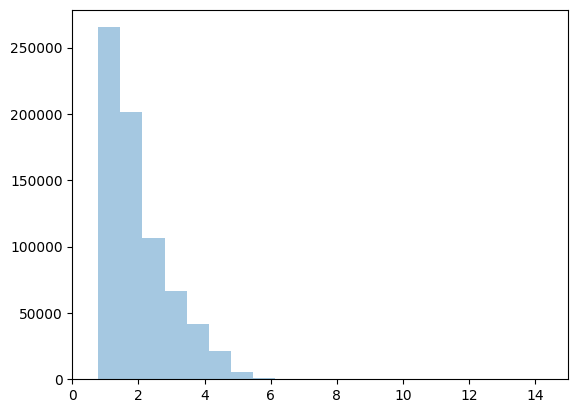

In [173]:
plt.figure()
sns.distplot(np.square(dist_train),
             bins = 10, 
             kde= False);
plt.xlim([0.0,15])

/tmp/ipykernel_8465/1411352472.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(dist_train,


Text(0.5, 0, 'Mahalanobis dist')

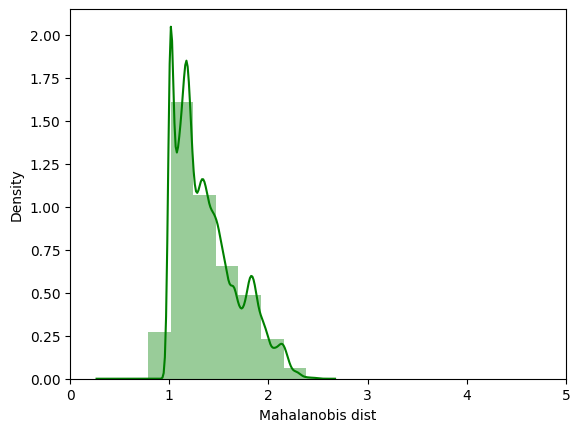

In [174]:
plt.figure()
sns.distplot(dist_train,
             bins = 10, 
             kde= True, 
            color = 'green');
plt.xlim([0.0,5])
plt.xlabel('Mahalanobis dist')

In [175]:
anomaly_train = pd.DataFrame()
anomaly_train['Mob dist']= dist_train
anomaly_train['Thresh'] = threshold
# If Mob dist above threshold: Flag as anomaly
anomaly_train['Anomaly'] = anomaly_train['Mob dist'] > anomaly_train['Thresh']
anomaly_train.index = X_train_PCA.index


In [176]:
anomaly_train

,Mob dist,Thresh,Anomaly
0,1.031175,2.759883,False
1,1.000841,2.759883,False
2,1.013827,2.759883,False
3,1.003519,2.759883,False
4,1.018017,2.759883,False
...,...,...,...
709085,1.461433,2.759883,False
709086,1.407574,2.759883,False
709087,1.466437,2.759883,False
709088,1.513770,2.759883,False


<Axes: >

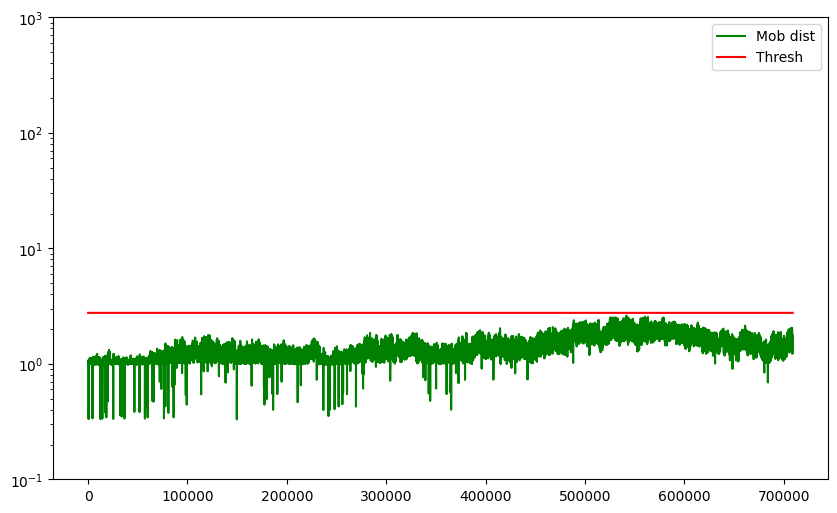

In [177]:
anomaly_train.plot(logy=True, figsize = (10,6), ylim = [1e-1,1e3], color = ['green','red'])